In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from pyspark import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, Bucketizer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.stat import Statistics
from pyspark.mllib.evaluation import MulticlassMetrics

from elephas.ml_model import ElephasEstimator
from elephas import optimizers as elephas_optimizers

#### Exploratory data analysis (EDA)

In [3]:
# Carrega dataset do desafio (basta descompactar todos na mesma pasta)
#display(dbutils.fs.ls("dbfs:/FileStore/tables/"))
df_desafio = spark.read.format("csv").options(header='true').load("/FileStore/tables/*.csv")

In [4]:
# Elimina na's e duplicados do df
df_desafio_v2 = df_desafio.dropna(how='any').dropDuplicates()

# Ajusta tipo de colunas
df_desafio_v2 = df_desafio_v2.selectExpr(
  'cast(time as timestamp) time',
  'ca',
  'unit',
  'scp',
  'station',
  'linename',
  'division',
  'desc',
  'cast(entries as int) entries',
  'cast(exits as int) exits'
)

# Features para visão temporal
df_desafio_v2 = df_desafio_v2.withColumn(
  "dt_year",
  year(col("time"))
).withColumn(
  "dt_month",
  month(col("time"))
).withColumn(
  "dt_day",
  dayofmonth(col("time"))
).withColumn(
  "dt_dayofy",
  dayofyear(col("time"))  
).withColumn(
  "dt_hour",
  hour(col("time"))
).withColumn(
  "dt_min",
  minute(col("time"))
).withColumn(
  "dt_week_no",
  weekofyear(col("time"))
).withColumn(
  "dt_int",
  unix_timestamp(col("time"))
).withColumn(
  "dt_month_year",
  date_format(col("time"), "Y-MM")
)

In [5]:
# Intervalos para buckets
splits = [-30000000, -20000000, -10000000, 0.0, 10000000, 20000000, 30000000]

# ===> Bucket: 'entries'
# dataFrame = df_desafio_v2.select(col('entries'))
# bucketizer = Bucketizer(splits=splits, inputCol="entries", outputCol="bucketedFeatures")
# bucketedData_entries = bucketizer.transform(dataFrame)
# sorted(bucketedData_entries.groupBy("bucketedFeatures").count().collect())
# [Row(bucketedFeatures=0.0, count=15721),
#  Row(bucketedFeatures=1.0, count=4028),
#  Row(bucketedFeatures=2.0, count=496),
#  Row(bucketedFeatures=4.0, count=71457425), ==> Begin
#  Row(bucketedFeatures=5.0, count=5052549),  <== End
#  Row(bucketedFeatures=6.0, count=278162),
#  Row(bucketedFeatures=7.0, count=2237294)]

# ===> Bucket: 'exits'
# dataFrame = df_desafio_v2.select(col('exits'))
# bucketizer = Bucketizer(splits=splits, inputCol="exits", outputCol="bucketedFeatures")
# bucketedData_exits = bucketizer.transform(dataFrame)
# sorted(bucketedData_exits.groupBy("bucketedFeatures").count().collect())
# [Row(bucketedFeatures=0.0, count=30576),
#  Row(bucketedFeatures=2.0, count=576),
#  Row(bucketedFeatures=3.0, count=1),
#  Row(bucketedFeatures=4.0, count=73751241), ==> Begin
#  Row(bucketedFeatures=5.0, count=3698911),  <== End
#  Row(bucketedFeatures=6.0, count=413740),
#  Row(bucketedFeatures=7.0, count=1150630)]

# Parâmetros para filtros de outliers
outlier_begin = 0
outlier_end = 20000000

df_desafio_v2 = df_desafio_v2.where((col('entries')>=outlier_begin) & (col('entries')<=outlier_end) & (col('exits')>=outlier_begin) & (col('exits')<=outlier_end))

In [6]:
# Check: 79.609.191 / 79.130.015 / 79.045.675 / 75.923.980
count_desafio = df_desafio.count()
count_desafio_na = df_desafio.dropna(how='any').count()
count_desafio_final = df_desafio.dropna(how='any').dropDuplicates().count()
count_desafio_outliers = df_desafio_v2.count()

df_amostras = sc.parallelize([
  ('antes',count_desafio,0,0,0,0),
  ('depois',0,count_desafio_final,count_desafio-count_desafio_na,count_desafio_na-count_desafio_final,count_desafio_final-count_desafio_outliers)
]).toDF(['AMOSTRAS','TOTAL','UNICO','NA','DUPLICADO','OUTLIERS'])

display(df_amostras)

In [7]:
df_amostras_v2 = sc.parallelize([
  ('',count_desafio-count_desafio_na,count_desafio_na-count_desafio_final,count_desafio_final-count_desafio_outliers)
]).toDF(['AMOSTRAS','NA','DUPLICADO','OUTLIERS'])

display(df_amostras_v2)

In [8]:
# Método para variáveis categóricas (dummys) ~14.59 minutes
lista_idx = ['ca', 'unit', 'scp', 'station', 'linename', 'division', 'desc']
indexers = [StringIndexer(inputCol=column,outputCol=column+"_idx").fit(df_desafio_v2) for column in lista_idx]
pipeline = Pipeline(stages=indexers)
df_desafio_v2 = pipeline.fit(df_desafio_v2).transform(df_desafio_v2)
#display(df_desafio_v2)

In [9]:
df_desafio_v2.write.parquet("/FileStore/tables/df_desafio.parquet")
df_desafio_num.write.parquet("/FileStore/tables/df_desafio_ml.parquet")

In [10]:
df_desafio = spark.read.parquet("/FileStore/tables/df_desafio.parquet")
df_desafio.registerTempTable("df_desafio")

df_desafio_graf = df_desafio.groupBy(
  'dt_month_year',
  'dt_year',
  'dt_month',
  'dt_day',
  'dt_hour'
).agg(
  sum('entries'),
  sum('exits')
).orderBy(
  "dt_month_year"
)

In [11]:
# Descritiva das variáveis de interesse
var_interesse = 'entries' #exits
df = sqlContext.sql("select 'entries' as var, min(entries) as minimo,percentile_approx(entries, 0.5) as mediana, int(avg(entries)) as media, max(entries) as maximo from df_desafio union select 'exits' as var, min(exits) as minimo,percentile_approx(exits, 0.5) as mediana, int(avg(exits)) as media, max(exits) as maximo from df_desafio")
df.show(10)

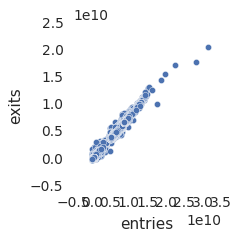

In [12]:
# Relação direita entre variáveis
var_interesse = 'exits'
colunas = ['dt_year', 'dt_month', 'dt_day', 'dt_hour','entries', 'exits']

sns.pairplot(df,x_vars='entries',y_vars=var_interesse)
display()

In [13]:
# Base para Regressão Simples
df_desafio_rl = df_desafio.groupBy(  
  'dt_year',
  'dt_month',
  'ca_idx',
  'unit_idx',
  'scp_idx',
  'station_idx',
  'linename_idx',
  'division_idx',
  'desc_idx'
).agg(
  sum('entries'),
  sum('exits')
)
#df_desafio_rl.count()
df_rl = df_desafio_rl.toPandas()
df_rl.columns = ['dt_year', 'dt_month', 'ca_idx', 'unit_idx', 'scp_idx', 'station_idx','linename_idx', 'division_idx', 'desc_idx', 'entries','exits']

In [14]:
# Regressão Simples
var_interesse = 'entries'
colunas = df_rl.columns

fig, ax = plt.subplots(3, 5, figsize = (15, 10))

for i, ax in enumerate(fig.axes):
    if i < len(df_rl.columns) - 1:
        sns.regplot(x=colunas[i],y=var_interesse, data=df_rl, ax=ax)
display()

In [15]:
df_rl[:1000]

Out[115]: 
 dt_year dt_month ca_idx unit_idx scp_idx station_idx linename_idx \
0 2010 4 85.0 24.0 28.0 17.0 26.0 
1 2010 4 5.0 3.0 91.0 41.0 0.0 
2 2010 4 42.0 32.0 25.0 22.0 9.0 
3 2010 4 276.0 143.0 9.0 132.0 5.0 
4 2010 5 301.0 285.0 2.0 243.0 0.0 
5 2010 5 540.0 80.0 44.0 80.0 0.0 
6 2010 5 512.0 365.0 0.0 372.0 6.0 
7 2010 5 105.0 163.0 15.0 151.0 2.0 
8 2010 5 480.0 356.0 2.0 306.0 17.0 
9 2010 5 50.0 52.0 21.0 29.0 13.0 
10 2010 5 11.0 2.0 37.0 13.0 41.0 
11 2010 5 130.0 40.0 23.0 4.0 24.0 
12 2010 5 306.0 179.0 6.0 95.0 93.0 
13 2010 6 22.0 12.0 90.0 60.0 0.0 
14 2010 6 319.0 296.0 2.0 299.0 21.0 
15 2010 6 662.0 79.0 1.0 79.0 8.0 
16 2010 6 43.0 99.0 31.0 135.0 1.0 
17 2010 6 200.0 38.0 28.0 35.0 0.0 
18 2010 6 603.0 162.0 2.0 193.0 12.0 
19 2010 6 631.0 426.0 2.0 365.0 50.0 
20 2010 6 81.0 130.0 14.0 123.0 2.0 
21 2010 6 481.0 129.0 3.0 20.0 0.0 
22 2010 6 648.0 194.0 1.0 38.0 11.0 
23 2010 6 398.0 44.0 49.0 66.0 27.0 
24 2010 6 538.0 140.0 17.0 165.0 2.0 
25 2010 8 588.0 403.0 2.0 357.0 6.0 
26 2010 8 662.0 79.0 1.0 79.0 8.0 
27 2010 8 564.0 249.0 0.0 88.0 1.0 
28 2010 8 612.0 268.0 6.0 225.0 35.0 
29 2010 8 536.0 74.0 9.0 73.0 5.0 
.. ... ... ... ... ... ... ... 
70 2011 1 451.0 343.0 1.0 292.0 11.0 
71 2011 1 39.0 4.0 51.0 19.0 28.0 
72 2011 1 39.0 4.0 10.0 19.0 28.0 
73 2011 1 483.0 358.0 0.0 353.0 19.0 
74 2011 1 249.0 261.0 1.0 61.0 102.0 
75 2011 1 210.0 54.0 38.0 18.0 13.0 
76 2011 1 2.0 0.0 32.0 1.0 9.0 
77 2011 1 115.0 48.0 33.0 46.0 57.0 
78 2011 2 12.0 59.0 16.0 3.0 43.0 
79 2011 2 140.0 77.0 2.0 77.0 3.0 
80 2011 2 408.0 217.0 3.0 9.0 11.0 
81 2011 2 133.0 180.0 1.0 161.0 1.0 
82 2011 2 679.0 448.0 2.0 371.0 30.0 
83 2011 2 399.0 319.0 0.0 316.0 4.0 
84 2011 2 42.0 32.0 10.0 22.0 9.0 
85 2011 2 65.0 5.0 160.0 0.0 14.0 
86 2011 2 193.0 54.0 4.0 18.0 13.0 
87 2011 2 524.0 144.0 12.0 133.0 6.0 
88 2011 4 265.0 73.0 32.0 6.0 29.0 
89 2011 4 7.0 23.0 61.0 26.0 46.0 
90 2011 4 428.0 330.0 3.0 236.0 30.0 
91 2011 4 333.0 301.0 0.0 307.0 38.0 
92 2011 4 247.0 90.0 9.0 117.0 66.0 
93 2011 4 547.0 383.0 0.0 186.0 30.0 
94 2011 4 484.0 170.0 2.0 128.0 4.0 
95 2011 4 453.0 345.0 2.0 344.0 17.0 
96 2011 4 85.0 24.0 33.0 17.0 26.0 
97 2011 4 77.0 37.0 27.0 27.0 36.0 
98 2011 4 501.0 235.0 7.0 6.0 0.0 
99 2011 5 148.0 28.0 27.0 12.0 31.0 

 division_idx desc_idx entries exits 
0 1.0 0.0 141601091 94231893 
1 3.0 0.0 10005884 7949856 
2 0.0 0.0 27206944 13067166 
3 1.0 0.0 78781131 8992771 
4 0.0 0.0 825116596 105601157 
5 0.0 0.0 0 1108 
6 2.0 0.0 1036283602 1066103895 
7 0.0 0.0 1215963491 413017749 
8 0.0 4.0 68323234 45688190 
9 0.0 0.0 1120707196 393564875 
10 0.0 0.0 80968217 152570490 
11 2.0 0.0 700709529 288620167 
12 1.0 0.0 145111161 387556888 
13 3.0 0.0 109434578 41426105 
14 2.0 0.0 334832168 301694561 
15 1.0 0.0 402922533 322600560 
16 0.0 0.0 271524345 315430677 
17 0.0 0.0 30653372 5128450 
18 1.0 0.0 145781680 145777692 
19 2.0 0.0 605894147 444521896 
20 0.0 0.0 221515848 103137205 
21 0.0 0.0 1202417957 767751774 
22 0.0 0.0 532817460 434222174 
23 2.0 0.0 108859844 34754763 
24 0.0 0.0 122064 169 
25 2.0 0.0 490024317 932794854 
26 1.0 0.0 423152247 339245509 
27 0.0 0.0 995578709 335322290 
28 1.0 0.0 136118066 71021968 
29 1.0 12.0 447489644 286381121 
.. ... ... ... ... 
70 0.0 0.0 860588322 523265006 
71 1.0 0.0 764259271 950208212 
72 1.0 0.0 332791506 493329431 
73 1.0 6.0 57320285 40749226 
74 2.0 3.0 90690158 151809202 
75 0.0 5.0 3444756 5239897 
76 0.0 4.0 26913 55504 
77 1.0 10.0 31028305 39470364 
78 2.0 0.0 690772164 126640828 
79 1.0 0.0 53513348 30420170 
80 0.0 0.0 287507642 87975648 
81 0.0 0.0 199713882 210955692 
82 0.0 0.0 1438709208 228523622 
83 0.0 6.0 65340633 7915955 
84 0.0 0.0 634341508 468945841 
85 1.0 0.0 841274107 384190298 
86 0.0 4.0 14157303 18565340 
87 2.0 0.0 289820477 374481224 
88 1.0 0.0 254138279 684545455 
89 1.0 0.0 185909557 103912769 
90 0.0 0.0 1354704605 229295834 
91 2.0 0.0 168616693 2099214310 
92 2.0 0.0 143971699 44140320 
93 0.0 0.0 547752338 58

#### Carga de Parquet para modelos

In [17]:
# Carrega Parquet
df_desafio_pqt = spark.read.parquet("/FileStore/tables/df_desafio.parquet")
df_desafio_num = df_desafio_pqt.select(
  'entries','exits','dt_year','dt_month','dt_day','dt_dayofy',
  'dt_hour','dt_min','dt_week_no','dt_int','ca_idx','unit_idx',
  'scp_idx','station_idx','linename_idx','division_idx','desc_idx'
)

#### Correlação entre features

In [19]:
# Gera matriz de correlação
col_names = df_desafio_num.columns
features = df_desafio_num.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
spark.createDataFrame(corr_df).write.parquet("/FileStore/tables/corr_df.parquet")

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 

 Py4JJavaError : An error occurred while calling o2999.parquet.
: org.apache.spark.sql.AnalysisException: path dbfs:/FileStore/tables/corr_df.parquet already exists.;
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:148)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:110)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:128)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:143)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$5.apply(SparkPlan.scala:183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:114)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:114)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:690)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:690)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withCustomExecutionEnv$1.apply(SQLExecution.scala:91)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:227)
	at org.apache.spark.sql.execution.SQLExecution$.withCustomExecutionEnv(SQLExecution.scala:86)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:157)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:690)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:290)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:284)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:232)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:579)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)


During handling of the above exception, another exception occurred:

 AnalysisException Traceback (most recent call last)
 <command-1146625930861805> in <module> 
 4 corr_df = pd . DataFrame ( corr_mat ) 
 5 corr_df . index , corr_df . columns = col_names , col_names
 ----> 6 spark . createDataFrame ( corr_df ) . write . parquet ( "/FileStore/tables/corr_df.parquet" ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, path, mode, partitionBy, compression) 
 839 self . 

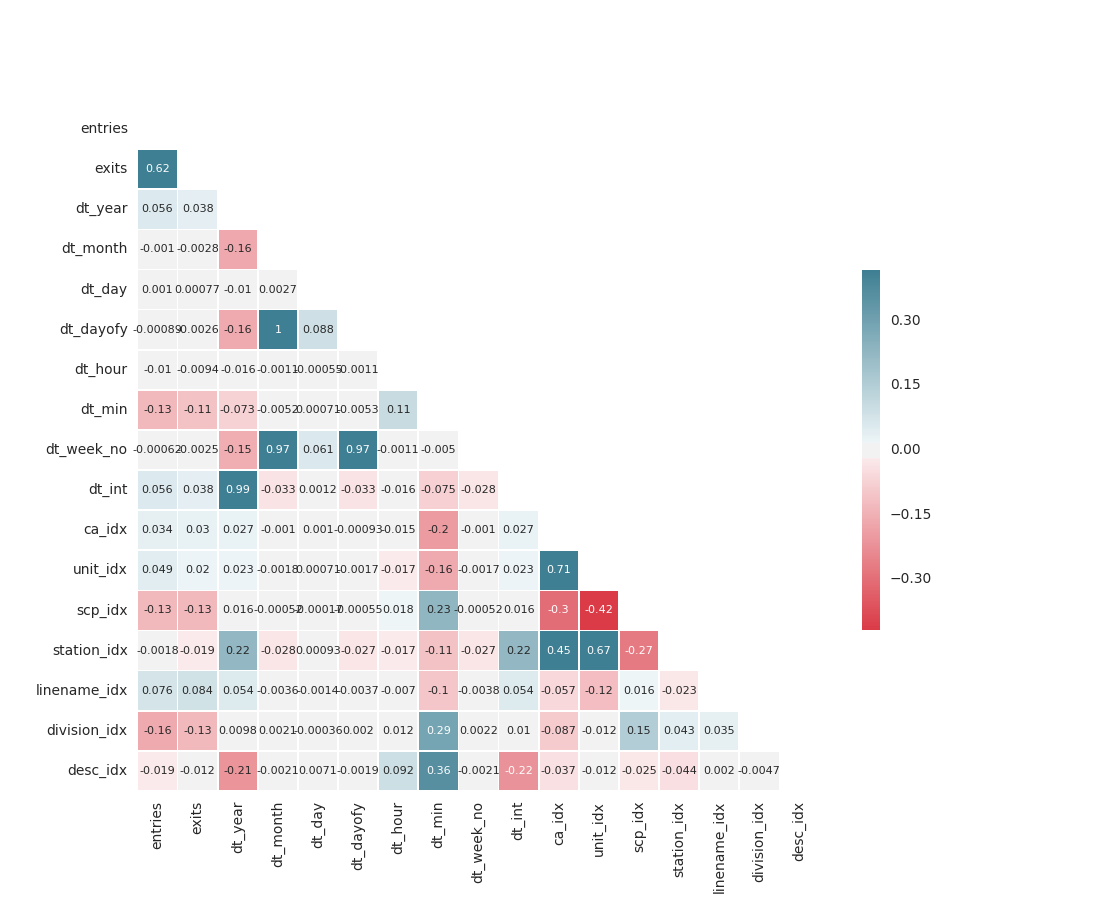

In [20]:
# Matriz de correlação - Gráfio
#corr_pq = spark.read.parquet("/FileStore/tables/corr_df.parquet")
corr = corr_df

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True, annot_kws={"size": 8}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

display()

#### Modelo de Machine Learning - Regressão Linear

In [22]:
# Verorização de features
colunas = ['exits', 'dt_year', 'dt_month', 'dt_day', 'dt_dayofy', 'dt_hour', 'dt_min', 'dt_week_no', 'dt_int', 'ca_idx', 'unit_idx', 'scp_idx', 'station_idx', 'linename_idx', 'division_idx', 'desc_idx']
vectorAssembler = VectorAssembler(inputCols = colunas, outputCol = 'features')
vdf_desafio_num = vectorAssembler.transform(df_desafio_num)
vdf_desafio_num.take(1)

# Seleciona features de interesse
vdf_desafio_num = vdf_desafio_num.select(['features', 'entries'])
vdf_desafio_num.show(3)

# Split para dados de treino/teste
splits = vdf_desafio_num.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [23]:
# Treinando os dados de treino para predizer os dados de teste
lr = LinearRegression(featuresCol = 'features', labelCol='entries', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

#Salva modelo treinado
lr_model.save("/FileStore/tables/lr_model")

In [24]:
#Resumo do treinamento
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

# Resumo do modelo treinado
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [25]:
# Descritiva da variável de interesse treinada
train_df.describe().show()

In [26]:
# Predição dos dados de teste vs Real
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","entries","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="entries",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

# Resultado RMSE do modelo de teste
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

In [27]:
# Histograma para residuals
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
#display(trainingSummary.residuals)

#### Modelo de Deep Learning - Elephas

In [29]:
# Etapa 01 - Transformações: VectorAssembler

# Variáveis para modelo
features = ['entries', 'exits', 'dt_year', 'dt_month', 'dt_day', 'dt_dayofy', 'dt_hour', 'dt_min', 'dt_week_no', 'dt_int', 'ca_idx', 'unit_idx', 'scp_idx', 'station_idx', 'linename_idx', 'division_idx', 'desc_idx']
var_predict = 'entries'
features.remove(var_predict)

# Vetorização de features
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_desafio = vectorAssembler.transform(df_desafio_num)

# Seleciona features + interesse (y)
df_desafio = df_desafio.select(['features', var_predict])

# Divisão de dados para treino e teste
splits = df_desafio.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [30]:
# Etapa 02 - Transformações: StringIndexer & StandardScaler
string_indexer = StringIndexer(inputCol=var_predict, outputCol="index_category")
fitted_indexer = string_indexer.fit(train_df)
indexed_df = fitted_indexer.transform(train_df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
fitted_scaler = scaler.fit(indexed_df)
scaled_df = fitted_scaler.transform(indexed_df)

In [31]:
# Keras Deep Learning model
nb_classes = train_df.select(var_predict).distinct().count()
input_dim = len(train_df.select("features").first()[0])

model = Sequential()
model.add(Dense(512, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [32]:
# Define elephas optimizer (which tells the model how to aggregate updates on the Spark master)
Adadelta = elephas_optimizers.Adadelta()

# Initialize SparkML Estimator and set all relevant properties
estimator = ElephasEstimator()
estimator.setFeaturesCol("scaled_features")             # These two come directly from pyspark,
estimator.setLabelCol("index_category")                 # hence the camel case. Sorry :)
estimator.set_keras_model_config(model.to_yaml())       # Provide serialized Keras model
estimator.set_optimizer_config(Adadelta.get_config())   # Provide serialized Elephas optimizer
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(2)  # We just use one worker here. Feel free to adapt it.
estimator.set_epochs(20) 
estimator.set_batch_size(128)
estimator.set_verbosity(1)
estimator.set_validation_split(0.15)
estimator.set_loss('squaredError')

In [33]:
# SparkML Pipelines
pipeline = Pipeline(stages=[string_indexer, scaler, estimator])

In [34]:
# Bug encontrado no fit, tentando resolver: https://github.com/maxpumperla/elephas/issues/122
# Fitting and evaluating the pipeline
fitted_pipeline = pipeline.fit(train_df) # Fit model to data

In [35]:
prediction = fitted_pipeline.transform(train_df) # Evaluate on train data.
# prediction = fitted_pipeline.transform(test_df) # <-- The same code evaluates test data.
pnl = prediction.select("index_category", "prediction")

prediction_and_label = pnl.map(lambda row: (row.index_category, row.prediction))
metrics = MulticlassMetrics(prediction_and_label)
print(metrics.precision())